In [28]:
import pickle5 as pickle
import json
from sklearn.metrics import ndcg_score
import pandas as pd
from scipy.stats import wilcoxon
import plotly.express as px
from collections import defaultdict
import math

In [29]:
# settings
plot_individual_results = False

Load prediction explanations and benchmark

In [30]:
with open('../../data/commonsense_benchmark/v2/commonsense_benchmark_for_analysis.json', 'r') as f:
    benchmark = json.load(f)

In [33]:
results_dir = '../../results/linklogic/'

results = dict()
experiments = {'baseline': '', 'child-removed': '_fb12'}
hop_settings = ['1hop', '2hop', 'all']

for experiment, exp_str in experiments.items():
    results[experiment] = dict()
    
    for hops in hop_settings:
        with open(f'{results_dir}/parents_analysis_ComplEx_{hops}_logsum_True_alpha_0.2{exp_str}.pickle', 'rb') as f:
            results[experiment][hops] = pickle.load(f)

Utility functions

In [60]:
def get_results_for_query_triple(results, triple):
    out = None
    for i, res in enumerate(results):
        if res['query_triple'] == triple:
            out = res
            break
    #if out is None:
    #    print('Warning: did not find query triple in results')
    return out

def stringify_path(path):
    return '--'.join(path)

def extract_feature_df_from_results(res, bmk_df):
    rows = []
    for f in res:
        path = stringify_path(f['path'])
        path_score = f['kge_score']['path_score']
        coef = f['coef']
        rows.append({'path': path,
                   'coefficient': coef,
                   'coefficient_product': coef*path_score,
                   'baseline_path_score': path_score,
                   'label': int(path in set(bmk_df.path))})
    df = pd.DataFrame(rows)
    df['random'] = 0
    df = df.merge(bmk_df, on='path', how='left')
    df['bmk_confidence'] = df['bmk_confidence'].fillna(0)
    df['bmk_category'] = df['bmk_category'].fillna('non-benchmark')
    return df

def extract_bmk_paths_as_df(bmk):
    rows = []
    for p in bmk['explanatory_paths']:
        row = {'path': stringify_path(p['path']),
               'bmk_confidence': p['confidence'],
               'bmk_category': p['category']}
        rows.append(row)
    return pd.DataFrame(rows)
    
def mean_diffs_by_confidence(df):
    if has_multi_confidence_bmks(df):     
        levels = set(df.bmk_confidence).difference({0})
        assert len(levels) == 2
        low_confidence = str(min(levels))
        high_confidence = str(max(levels))
        all_means = mean_by_confidence(df, column='coefficient')
        diff = all_means[high_confidence] - all_means[low_confidence]
    else:
        diff = math.nan
    return diff

def mean_by_confidence(df, column='coefficient'):
    levels = set(df.bmk_confidence)
    means = dict()
    for level in levels:
        means[str(level)] = df.loc[df.bmk_confidence == level, column].mean()
    return means

def has_multi_confidence_bmks(df):
    return len(set(df.bmk_confidence).difference({0})) > 1

def get_bmk_results(df):
    return df[df.label == 1]




Compute metrics

In [104]:
# compute metrics
metrics = []
df = defaultdict(dict)
colnames = ['bmk_category',	'coefficient',	'rank',	'experiment',	'features',	'query_triple']
all_stats = pd.DataFrame(columns=colnames)

for i, bmk in enumerate(benchmark):
    
    if bmk['category'] == 'location':
        continue
        
    triple = bmk['query_triple']
    s_triple = stringify_path(triple)
    
    bmk_df = extract_bmk_paths_as_df(bmk)
    num_true = bmk_df.shape[0]
    
    for experiment in experiments.keys():

        for hops in hop_settings:

            res = get_results_for_query_triple(results[experiment][hops], triple)

            if res:
                feature_df = extract_feature_df_from_results(res['linklogic_features'], bmk_df) 
                num_true_candidates = feature_df['label'].sum()

                if num_true_candidates > 0:
                    
                    
                    stats = get_explanation_stats(feature_df, experiment=experiment, features=hops, query_triple=s_triple)
                    all_stats = pd.concat([all_stats, stats], axis=0)
                    
                    
                    y_true = [feature_df['label']]
                    fidelity_train = res['linklogic_metrics']['train_acc']
                    fidelity_test = res['linklogic_metrics']['test_acc']
                    kge_score = float(res['query_triple_kge_score'])
                    coef_differential = mean_diffs_by_confidence(feature_df)
                    coef_means = mean_by_confidence(feature_df, column='coefficient')
                    metrics.append({'experiment': experiment,
                                    'hops': hops,
                                    'score_heuristic': ndcg_score(y_true=y_true, y_score=[feature_df['baseline_path_score']]),
                                    'linklogic': ndcg_score(y_true=y_true, y_score=[feature_df['coefficient']]),
                                    'linklogic_product': ndcg_score(y_true=y_true, y_score=[feature_df['coefficient_product']]),
                                    'random': ndcg_score(y_true=y_true, y_score = [feature_df['random']]),
                                    'coef_differential': coef_differential,
                                    'coef_non_benchmark': coef_means.get('0.0'),
                                    'coef_benchmark_1': coef_means.get('1.0'),
                                    'coef_benchmark_2': coef_means.get('2.0'),
                                    'coef_benchmark_3': coef_means.get('3.0'),
                                    'num_true': num_true_candidates,
                                    'query_triple': s_triple,
                                    'query_triple_kge_score': kge_score,
                                    'fidelity_train': fidelity_train,
                                    'fidelity': fidelity_test})

                    if plot_individual_results:
                        fig = px.scatter(feature_df, x='baseline_path_score', y='coefficient', color='label', hover_data=["path"], title=f'{hops} features: {s_triple}')
                        fig.show()

M = pd.DataFrame(metrics)        

In [110]:
melt_stats = all_stats.melt(id_vars=['bmk_category', 'experiment', 'features', 'query_triple'])
melt_stats.head()

,bmk_category,experiment,features,query_triple,variable,value
0,child,baseline,1hop,publius_septimius_geta--parents--julia_domna,coefficient,0.831972
1,childs_sibling,baseline,1hop,publius_septimius_geta--parents--julia_domna,coefficient,0.224370
2,non-benchmark,baseline,1hop,publius_septimius_geta--parents--julia_domna,coefficient,0.001598
3,non-benchmark,baseline,2hop,publius_septimius_geta--parents--julia_domna,coefficient,0.005643
4,parents_spouse,baseline,2hop,publius_septimius_geta--parents--julia_domna,coefficient,0.097717


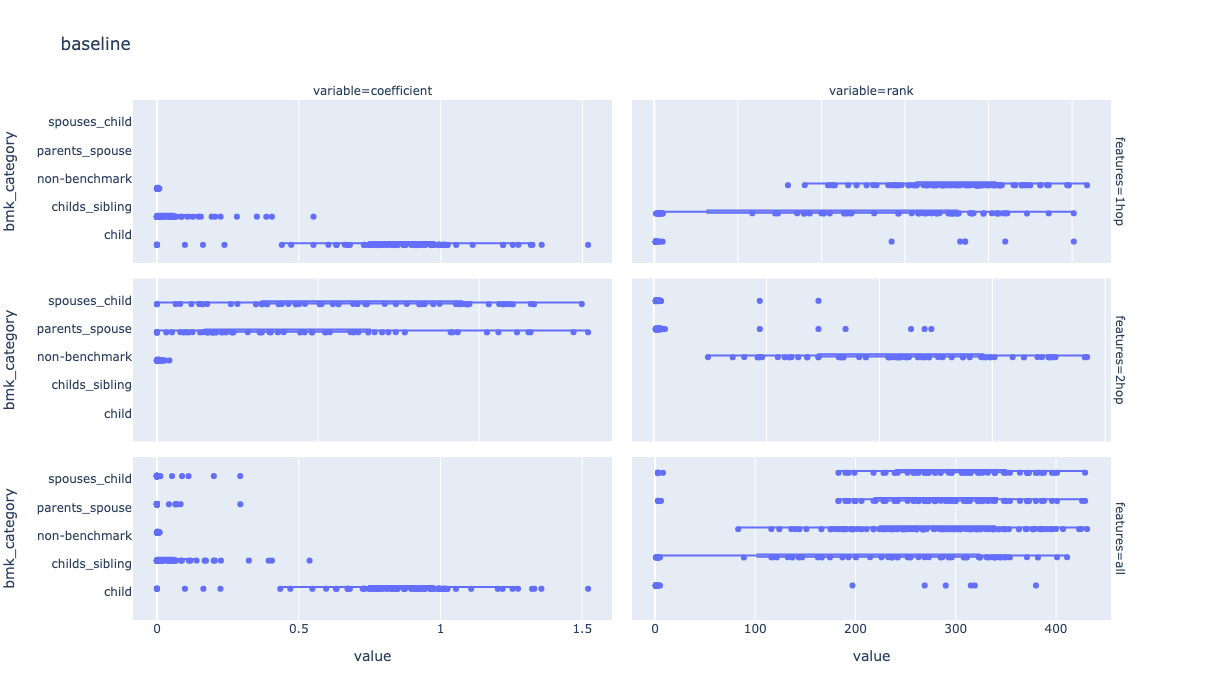

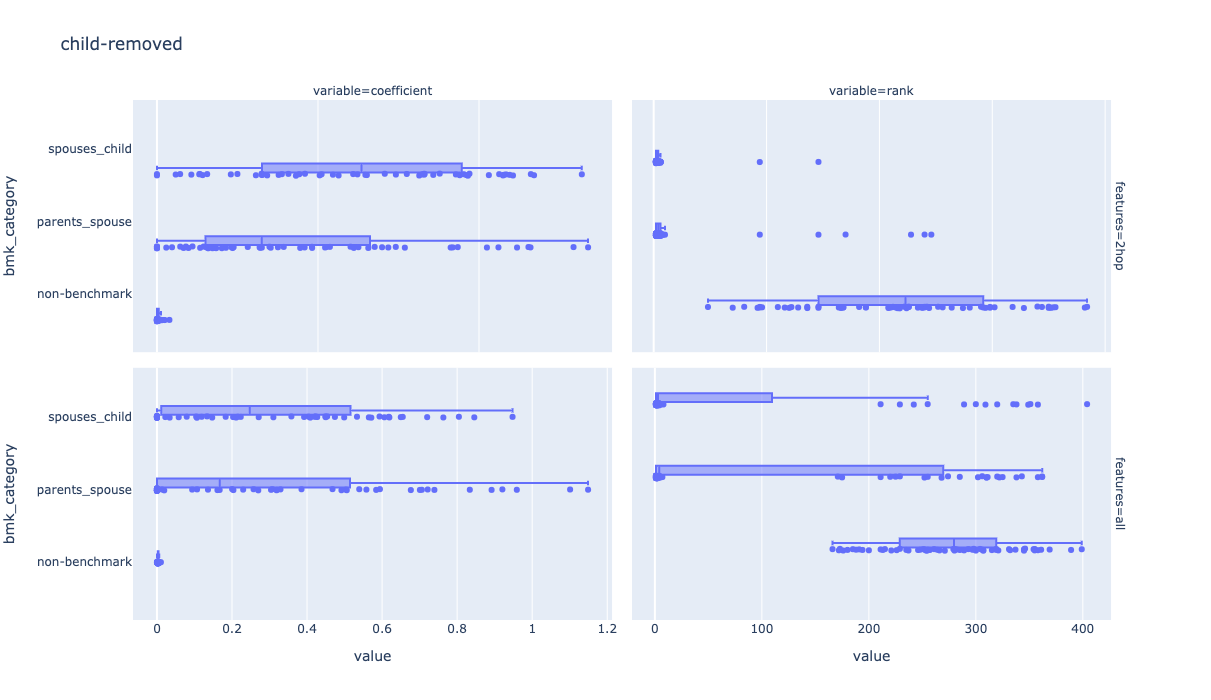

In [130]:
for experiment in experiments.keys():
    X = melt_stats[melt_stats['experiment'] == experiment]
    fig = px.box(X, y='bmk_category', x='value', facet_col='variable', facet_row='features',
                 hover_data=['query_triple'], title=experiment, height=700, width=900, points='all')
    fig.update_xaxes(matches=None)

In [97]:
def get_explanation_stats(df, rank_by='coefficient', **kwargs):
    df['rank'] = df[rank_by].rank(method='max', ascending=False)
    out = df.groupby('bmk_category', as_index=False)
    out = out[[rank_by, 'rank']].mean()
    for key, value in kwargs.items():
        out[key] = value
    return out

baseline


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14df1bf98>,
      dtype=object)

child-removed


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14e0305f8>,
      dtype=object)

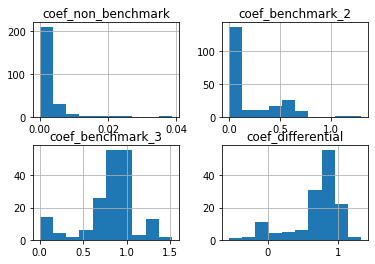

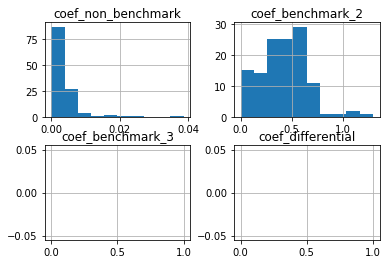

In [43]:
for exp, df in M.groupby('experiment'):
    print(exp)
    df[['coef_non_benchmark', 'coef_benchmark_2', 'coef_benchmark_3', 'coef_differential']].hist()

In [80]:
df.shape

(289, 9)

In [44]:
# m = M[['coef_non_benchmark', 'coef_benchmark_2', 'coef_benchmark_3', 'coef_differential', 'experiment']].melt()
# px.box(m, y='value', x='variable', title='Coefficient values for paths by benchmark confidence level', 
#       labels={'value': 'mean coefficient value'}, width=800, height=400, facet_row='experiment')

In [46]:
def plot_scatter_with_facets(M, x, y, color, palette='matter', filename=None, size=8, width=900, height=300):
    fig = px.scatter(M, x=x, y=y, color=color, facet_col='hops', facet_row='experiment', 
                     hover_data=["query_triple", "query_triple_kge_score"],
                     color_continuous_scale=palette, opacity=0.5, width=width, height=height)
    fig.add_shape(dict(type="line", x0=0, y0=0, x1=1.1, y1=1.1, line_width=1),
                       row="all", col="all",
                  line=dict(color="gray", width=1, dash="dot"))
    
    fig.update_traces(marker_size=size, marker_line={'width':0.5, 'color':'lightgrey'})
    
    fig.layout.plot_bgcolor = '#f0f0f0'
    fig.show()
    if filename is not None:
        fig.write_html(filename)

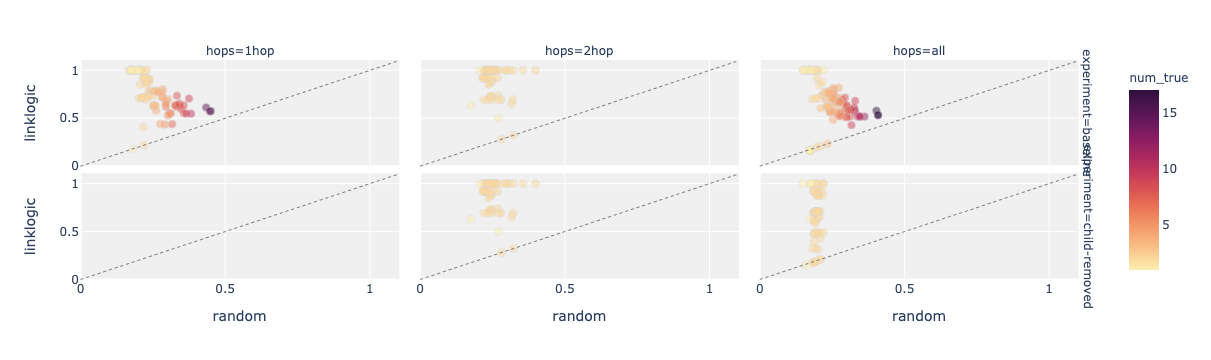

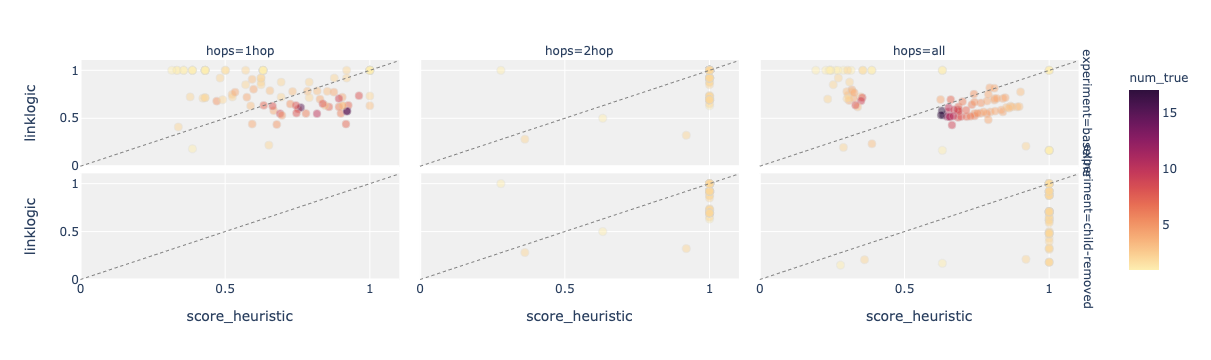

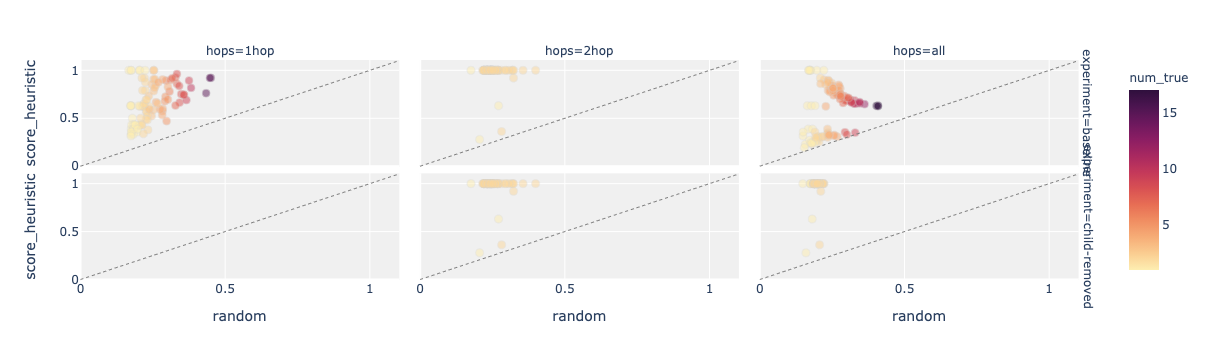

In [49]:
overlay = 'num_true'
plot_scatter_with_facets(M=M, x='random', y='linklogic', color=overlay, filename='LinkLogic_v_Random.html')
plot_scatter_with_facets(M=M, x='score_heuristic', y='linklogic', color=overlay, filename='LinkLogic_v_RawFeatureScores.html')
plot_scatter_with_facets(M=M, x='random', y='score_heuristic', color=overlay, filename='RawFeatureScores_v_Random.html')

In [ ]:
# Goal: show which paths are ranked where 